Train shape: (25000, 14) | Test shape: (23842, 14) | Submission shape: (23842, 2)

    age         workclass    education  education.num      marital.status  \
0   53  Self-emp-not-inc  Prof-school             15  Married-civ-spouse   
1   33  Self-emp-not-inc    Bachelors             13  Married-civ-spouse   
2   47           Private      HS-grad              9  Married-civ-spouse   
3   40           Private      HS-grad              9            Divorced   
4   39           Private      HS-grad              9  Married-civ-spouse   

         occupation    relationship                race     sex  capital.gain  \
0    Prof-specialty         Husband  Asian-Pac-Islander    Male             0   
1   Exec-managerial         Husband               White    Male             0   
2      Craft-repair         Husband               White    Male             0   
3      Craft-repair  Other-relative               White  Female             0   
4  Transport-moving         Husband               Whit

<AxesSubplot:xlabel='income>50K', ylabel='count'>

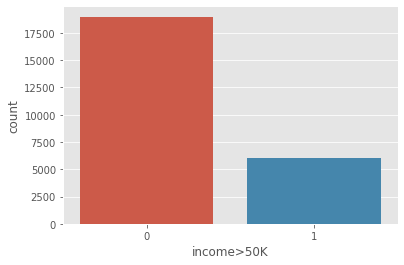

In [1]:
import csv
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing


# X Train
traindf = pd.read_csv("in-csv/train_final.csv")
# X Test
testdf = pd.read_csv("in-csv/test_final.csv")

#try dropping fnlwgt
traindf = traindf.drop('fnlwgt', axis=1)
testdf = testdf.drop('fnlwgt', axis=1)

# X Sample
sampledf = pd.read_csv("in-csv/sample_final.csv")


# -----------Data Exploration-------------

print(f'Train shape: {traindf.shape}',
      f'Test shape: {testdf.shape}',
      f'Submission shape: {sampledf.shape}', sep=' | ')

print("\n", traindf.head())

sns.countplot(traindf.iloc[:, -1])

In [2]:
# View uniques values of train data

traindf.index.nunique(), len(traindf.index)

traindf.head()

nunique_vals = list()

for column in traindf:
    nunique_vals.append(traindf[column].nunique())
    
pd.DataFrame({'columns': traindf.columns,
              'num_of_unique': nunique_vals})

,columns,num_of_unique
0,age,73
1,workclass,9
2,education,16
3,education.num,16
4,marital.status,7
5,occupation,15
6,relationship,6
7,race,5
8,sex,2
9,capital.gain,117


In [3]:

# View uniques values of train and test data

all_df = pd.concat([traindf, testdf], axis=0, ignore_index=True)

all_df.index.nunique(), len(all_df.index)

all_df = all_df.drop('ID', axis=1)

all_df.head()

nunique_vals = list()

for column in all_df:
    nunique_vals.append(all_df[column].nunique())
    
pd.DataFrame({'columns': all_df.columns,
              'num_of_unique': nunique_vals})

,columns,num_of_unique
0,age,74
1,workclass,9
2,education,16
3,education.num,16
4,marital.status,7
5,occupation,15
6,relationship,6
7,race,5
8,sex,2
9,capital.gain,123


In [4]:
# Check for NaN Values

for column in all_df.columns:

    unique_values = all_df[column].unique()
    
    print(f'Statistics fot column: {column}')
    print(f'Column unique values:\n {unique_values}')
    print(f'Number of unique values: {len(unique_values)}')
    print(f'Number of NAN values: {all_df[column].isna().sum()}')
    #print(f'Number of ? values: {all_df.iloc[(all_df[column]=="?")].sum()}')
    print('_' * 50)

Statistics fot column: age
Column unique values:
 [53 33 47 40 39 55 22 27 37 79 31 19 21 56 26 42 30 35 68 38 34 32 72 24
 50 28 49 29 51 48 41 66 60 20 76 45 52 18 44 59 75 71 46 23 17 54 36 25
 57 43 58 64 61 70 90 81 85 62 65 69 67 80 63 77 78 73 84 74 88 83 82 87
 89 86]
Number of unique values: 74
Number of NAN values: 0
__________________________________________________
Statistics fot column: workclass
Column unique values:
 ['Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' 'Self-emp-inc' '?'
 'State-gov' 'Never-worked' 'Without-pay']
Number of unique values: 9
Number of NAN values: 0
__________________________________________________
Statistics fot column: education
Column unique values:
 ['Prof-school' 'Bachelors' 'HS-grad' 'Doctorate' 'Masters' 'Some-college'
 '11th' '12th' '5th-6th' 'Assoc-acdm' '9th' 'Preschool' 'Assoc-voc'
 '7th-8th' '10th' '1st-4th']
Number of unique values: 16
Number of NAN values: 0
__________________________________________________
Statistics fot

In [5]:
#Change missing values
def replace_missing(data):
    for col in data.columns:
        majority_class_index = np.argmax(np.unique(data[col], return_counts=True)[1])
        majority_value = np.unique(data[col])[majority_class_index]
        if majority_value == "?":
          newdata = data[data[col] != "?"]
          majority_class_index = np.argmax(np.unique(newdata[col], return_counts=True)[1])
          majority_value = np.unique(newdata[col])[majority_class_index]

        data[col] = np.where(data[col] == "?", majority_value, data[col])


replace_missing(all_df)

# Features encoding

# Possibly drop fnlwgt???
#all_df = all_df.drop('fnlwgt', axis=1)

categorical = ['workclass', 'education', 'marital.status', 'occupation',
               'relationship', 'race', 'sex', 'native.country']

continuous = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week']



# Use LabelEncoding to change string values to numbers

features = [x for x in all_df.columns 
            if x not in ['ID', 'income>50K'] + continuous]

for feat in tqdm(features):
    lbl_enc = preprocessing.LabelEncoder()
    
    all_df[feat] = lbl_enc.fit_transform(all_df[feat]. \
                                         fillna('-1'). \
                                         astype(str).values)
    
all_df['income>50K'] = all_df['income>50K'].fillna(-1)
all_df[continuous] = all_df[continuous].fillna(-2)


  0%|          | 0/8 [00:00<?, ?it/s]

KeyError: "['fnlwgt'] not in index"

In [ ]:
# Print Information

all_df.head()

all_df.shape

all_df.isna().sum().sum()

0

In [ ]:
# Prepare Data for Training and Testing

train = all_df[:traindf.shape[0]]
test = all_df[traindf.shape[0]:]

print(f'Train shape: {train.shape}',
      f'Test shape: {test.shape}', sep=' | ')

train.isna().sum().sum(), test.isna().sum().sum() 

train_data = train.drop('income>50K', axis=1).to_numpy()
train_target = train['income>50K'].to_numpy()

test_data = test.drop('income>50K', axis=1).to_numpy()

categorical = all_df.drop(['income>50K'] + continuous,
                          axis=1).columns

cat_cols_idx, cont_cols_idx = list(), list()

for idx, column in enumerate(all_df.drop('income>50K',
                                         axis=1).columns):
    if column in categorical:
        cat_cols_idx.append(idx)
    elif column in continuous:
        cont_cols_idx.append(idx)

train_data, train_target, test_data


Train shape: (25000, 15) | Test shape: (23842, 15)


(array([[    53,      5,  93449, ...,      0,     40,     18],
        [    33,      5, 123424, ...,      0,     40,     38],
        [    47,      3, 144844, ...,      0,     40,     38],
        ...,
        [    39,      3, 225544, ...,      0,     40,     30],
        [    53,      3, 346871, ...,      0,     46,     38],
        [    18,      3, 192321, ...,      0,     40,     38]]),
 array([1., 1., 0., ..., 0., 1., 0.]),
 array([[    33,      5, 222162, ...,      0,     40,     38],
        [    68,      3,  29240, ...,      0,     12,     38],
        [    34,      3, 103596, ...,      0,     40,     38],
        ...,
        [    67,      4, 182581, ...,      0,     20,     38],
        [    46,      1, 274689, ...,      0,     40,     38],
        [    66,      0,  47358, ...,      0,     40,     38]]))

In [ ]:
class NN(nn.Module):
    def __init__(self, hidden_width, depth):
        super(NN, self).__init__()
        layers = []
        input_layer = nn.Linear(14, hidden_width)
        
        activation_input = nn.Sigmoid()
        #activation_input = nn.Threshold()
        #activation_input = nn.Tanh()
        #activation_input = nn.ReLU()

        layers.append(input_layer)
        layers.append(activation_input)
        for i in range(depth-1):
            hidden_layer = nn.Linear(hidden_width, hidden_width)
            activation_hidden = nn.Sigmoid()
            #activation_hidden = nn.Threshold()
            #activation_hidden = nn.Tanh()
            #activation_hidden = nn.ReLU()

            layers.append(hidden_layer)
            layers.append(activation_hidden)

        output_layer = nn.Linear(hidden_width, 1)
        output_layer2 = nn.Sigmoid()
        layers.append(output_layer)
        layers.append(output_layer2)


        self.model = nn.Sequential(*layers)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

        self.model.apply(init_weights)

    def forward(self, X):
        input = np.float32(X)
        out = torch.from_numpy(input)
        out.requires_grad = True
        return self.model(out)

In [ ]:
#Training

print("\nTraining/Testing:\n")

depth = [3, 5, 9]
width = [5, 10, 25]
criterion = torch.nn.BCELoss()

for i in width:
    for j in depth:
        NeuralNet = NN(i, j)
        optimizer = torch.optim.Adam(NeuralNet.parameters(), lr=0.0005)

        for t in range(25):

            optimizer.zero_grad()

            # Forward pass: compute predicted y by passing x to the model.
            y_train_pred_tensor = NeuralNet.forward(train_data).flatten()

            y_train_np = np.float32(train_target)
            y_train_tensor = torch.from_numpy(y_train_np)
            y_train_tensor.requires_grad = True
            y_train_tensor = y_train_pred_tensor.flatten()

            loss = criterion(y_train_pred_tensor.flatten(), y_train_tensor)

            # Backward pass: compute gradient of the loss with respect to model
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

        #train error
        train_pred = NeuralNet.forward(train_data)
        train_pred = train_pred.detach().numpy().flatten()

        print(f"width: {i}, depth:{j}, roc_auc_score: {metrics.roc_auc_score(train_target, train_pred)}")

        #test predictions -> add to csv
        test_pred = NeuralNet.forward(test_data)
        test_pred = test_pred.detach().numpy().flatten()

        nn_predictions_df = pd.DataFrame({'ID': sampledf['ID'], 
                                   'Prediction': test_pred})

        nn_predictions_df.to_csv("out-csv/" + "width-" + str(i) + "-depth-" + str(j) + ".csv", index=False)




Training/Testing:

width: 5, depth:3, roc_auc_score: 0.474531131619236
width: 5, depth:5, roc_auc_score: 0.410141544342212
width: 5, depth:9, roc_auc_score: 0.4959275265957447
width: 10, depth:3, roc_auc_score: 0.5506401168383118
width: 10, depth:5, roc_auc_score: 0.4640368344899624
width: 10, depth:9, roc_auc_score: 0.4581766714523316
width: 25, depth:3, roc_auc_score: 0.6261635682077741
width: 25, depth:5, roc_auc_score: 0.4937841386657632
width: 25, depth:9, roc_auc_score: 0.5230104186280047


In [ ]:
import shutil
shutil.make_archive('nn-submissions', 'zip', 'out-csv')

'/Users/janalynjenn/Desktop/FinalProjectMachineLearning/nn-submissions.zip'

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Cat Boost

# X Train
traindf = pd.read_csv("in-csv/train_final.csv")
# X Test
testdf = pd.read_csv("in-csv/test_final.csv")
# X Sample
sampledf = pd.read_csv("in-csv/sample_final.csv")

#try dropping fnlwgt
# traindf = traindf.drop('fnlwgt', axis=1)
# testdf = testdf.drop('fnlwgt', axis=1)

X = traindf.drop('income>50K', axis=1)
y = traindf['income>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

test_data = testdf.drop('ID', axis=1)




cat_feats = ['workclass', 'education', 'marital.status', 'occupation',
               'relationship', 'race', 'sex', 'native.country']

best_params = {
    'bagging_temperature': 0.8, 
    'depth': 5, 
    'iterations': 11000,
    'l2_leaf_reg': 30,
    'random_strength': 0.8
}

model_cat = CatBoostRegressor(**best_params,
                                loss_function='RMSE',
                                eval_metric='AUC', 
                                nan_mode='Min',
                                random_seed=42,
                                thread_count=4,
                                verbose=True)

model_cat.fit(X_train, y_train,
              eval_set=(X_test, y_test), 
              cat_features=cat_feats,
              verbose_eval=300, 
              use_best_model=True,
              plot=True)


#CatBoost predictions

test_data = testdf.drop('ID', axis=1).to_numpy()

cat_predictions = model_cat.predict(test_data)

cat_predictions_df = pd.DataFrame({'ID': sampledf['ID'], 
                                   'Prediction': cat_predictions})

cat_predictions_df.to_csv('catboost_res_sub.csv', index=False)
                                




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8607538	best: 0.8607538 (0)	total: 58.6ms	remaining: 10m 44s
300:	test: 0.9179078	best: 0.9179078 (300)	total: 2.16s	remaining: 1m 16s
600:	test: 0.9201867	best: 0.9201873 (595)	total: 3.77s	remaining: 1m 5s
900:	test: 0.9208915	best: 0.9208981 (893)	total: 5.18s	remaining: 58s
1200:	test: 0.9217178	best: 0.9217178 (1195)	total: 6.61s	remaining: 53.9s
1500:	test: 0.9224851	best: 0.9224873 (1490)	total: 8.08s	remaining: 51.1s
1800:	test: 0.9228286	best: 0.9228497 (1779)	total: 9.53s	remaining: 48.7s
2100:	test: 0.9231976	best: 0.9232024 (2091)	total: 11s	remaining: 46.6s
2400:	test: 0.9234927	best: 0.9234927 (2398)	total: 12.5s	remaining: 44.8s
2700:	test: 0.9238891	best: 0.9238943 (2685)	total: 14.1s	remaining: 43.3s
3000:	test: 0.9241598	best: 0.9241598 (3000)	total: 15.7s	remaining: 41.8s
3300:	test: 0.9244325	best: 0.9244384 (3286)	total: 17.3s	remaining: 40.3s
3600:	test: 0.9246741	best: 0.9247015 (3489)	total: 18.8s	remaining: 38.7s
3900:	test: 0.9251220	best: 0.9251255